In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# gmm
from sklearn.mixture import GaussianMixture
# hdbscan
import hdbscan
# dbscan
from sklearn.cluster import DBSCAN
# kmeans
from sklearn.cluster import KMeans
# os
import os
# pickle
import pickle
# import norm
from scipy.stats import norm
# import Ellipses
from matplotlib.patches import Ellipse

# Check if 'has_changed_directory' is defined
if 'has_changed_directory' not in globals():
    # Change the working directory only if it hasn't been changed before
    os.chdir("..")
    # Set the flag to True after changing the directory
    has_changed_directory = True

In [3]:
# read data/traits_pred_log.csv
df_pred = pd.read_csv('data/traits_pred_log.csv', index_col=0)
# read data/traits_obs_log.csv
df_obs = pd.read_csv('data/traits_obs_log.csv', index_col=0)
# read error_pred_dist.pkl
with open('data/error_pred_dist.pkl', 'rb') as f:
    error_pred_dist = pickle.load(f)
# read data/gymnosperms.csv
df_gymno = pd.read_csv('data/gymnosperms.csv', index_col=0)
df_angio = pd.read_csv('data/angiosperms.csv', index_col=0)

df_gymno_pred = df_pred[df_pred.index.isin(df_gymno['accepted_bin'])]
df_gymno_obs = df_obs[df_obs.index.isin(df_gymno['accepted_bin'])]

In [16]:
# Calculate mean and std for each column
trait_stats = df_pred.describe().loc[['mean', 'std']].T

# Rename columns for LaTeX table
trait_stats.columns = ['Mean', 'Std. Dev.']


# add $$ to the column names
# trait_stats.index = ['${}$'.format(col) for col in trait_stats.index]

# Create a LaTeX table
latex_table = trait_stats.to_latex(index=True, caption='',
                                    label='tab:trait_stats', float_format='%.2f')

print(latex_table)

\begin{table}
\label{tab:trait_stats}
\begin{tabular}{lrr}
\toprule
 & Mean & Std. Dev. \\
\midrule
Bark thickness & 1.21 & 0.78 \\
Crown diameter & 2.39 & 0.49 \\
Crown height & 2.42 & 0.42 \\
Leaf K per mass & 2.14 & 0.42 \\
Leaf N per mass & 2.91 & 0.30 \\
Leaf P per mass & -0.02 & 0.43 \\
Leaf Vcmax per dry mass & -1.17 & 0.37 \\
Leaf area & 7.79 & 1.48 \\
Leaf density & -1.03 & 0.26 \\
Leaf thickness & -1.51 & 0.31 \\
Root depth & 0.95 & 0.88 \\
Seed dry mass & 4.05 & 2.42 \\
Specific leaf area & 2.45 & 0.38 \\
Stem conduit diameter & 3.36 & 0.32 \\
Stem diameter & -0.61 & 0.55 \\
Stomatal conductance & 5.03 & 0.46 \\
Tree height & 3.23 & 0.41 \\
Wood density & -0.55 & 0.23 \\
\bottomrule
\end{tabular}
\end{table}



In [19]:

# Calculate mean and std for each column
stats = df_pred.describe().loc[['mean', 'std']].T

# Round to 2 decimal places
stats = stats.round(2)

# Split the DataFrame into two halves
split_index = (len(stats) + 1) // 2  # Adjust to handle odd number of columns
left_half = stats.iloc[:split_index]
right_half = stats.iloc[split_index:]

# Combine into one LaTeX table with a single caption
latex_table = r'''
\begin{table}[ht]
\centering
\caption{Mean and Standard Deviation of DataFrame Columns}
\label{tab:stats}
\begin{tabular}{lrr@{\hskip 20pt}lrr}
\hline
Trait name & Mean & Std & Trait name & Mean & Std \\
\hline
'''

for (left_name, left_row), (right_name, right_row) in zip(left_half.iterrows(), right_half.iterrows()):
    latex_table += f"{left_name} & {left_row['mean']} & {left_row['std']} & {right_name} & {right_row['mean']} & {right_row['std']} \\\\\n"

# If there's an odd number of columns, the last column in the left_half will not be processed in the loop
if len(left_half) != len(right_half):
    last_row = left_half.iloc[-1]
    latex_table += f"{last_row.name} & {last_row['mean']} & {last_row['std']} &  &  &  \\\\\n"

latex_table += r'''
\end{tabular}
\end{table}
'''

print(latex_table)


\begin{table}[ht]
\centering
\caption{Mean and Standard Deviation of DataFrame Columns}
\label{tab:stats}
\begin{tabular}{lrr@{\hskip 20pt}lrr}
\hline
Trait name & Mean & Std & Trait name & Mean & Std \\
\hline
Bark thickness & 1.21 & 0.78 & Leaf thickness & -1.51 & 0.31 \\
Crown diameter & 2.39 & 0.49 & Root depth & 0.95 & 0.88 \\
Crown height & 2.42 & 0.42 & Seed dry mass & 4.05 & 2.42 \\
Leaf K per mass & 2.14 & 0.42 & Specific leaf area & 2.45 & 0.38 \\
Leaf N per mass & 2.91 & 0.3 & Stem conduit diameter & 3.36 & 0.32 \\
Leaf P per mass & -0.02 & 0.43 & Stem diameter & -0.61 & 0.55 \\
Leaf Vcmax per dry mass & -1.17 & 0.37 & Stomatal conductance & 5.03 & 0.46 \\
Leaf area & 7.79 & 1.48 & Tree height & 3.23 & 0.41 \\
Leaf density & -1.03 & 0.26 & Wood density & -0.55 & 0.23 \\

\end{tabular}
\end{table}



In [3]:
# normalize error
for trait in df_gymno_pred.columns:
    error_pred_dist[trait] = (error_pred_dist[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()
    df_gymno_pred[trait] = (df_gymno_pred[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()

# normalize the data
# df_gymno_pred_norm = (df_gymno_pred - df_gymno_pred.mean()) / df_gymno_pred.std()


C:\Users\pablo\AppData\Local\Temp\ipykernel_18932\23683145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred[trait] = (df_gymno_pred[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()


1 Dimensional Case - Crown Height

In [8]:
def resample_trait(X, error_list):
    sampled_error = np.random.choice(error_list, size=X.shape, replace=True)
    return X + sampled_error

Example resample: 


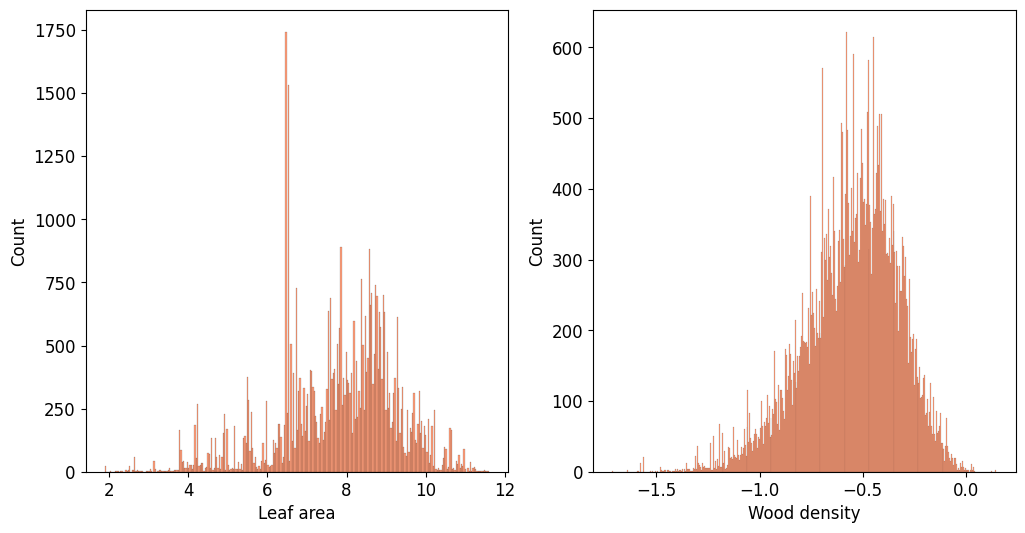

In [31]:
# PLOT HISTOGRAM FOR Leaf area and Wood density
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df_pred['Leaf area'], bins=300, ax=ax[0], color = 'coral')
sns.histplot(df_pred['Wood density'], bins=400, ax=ax[1], color='coral')
# fontsize
plt.rcParams.update({'font.size': 14})
plt.show()


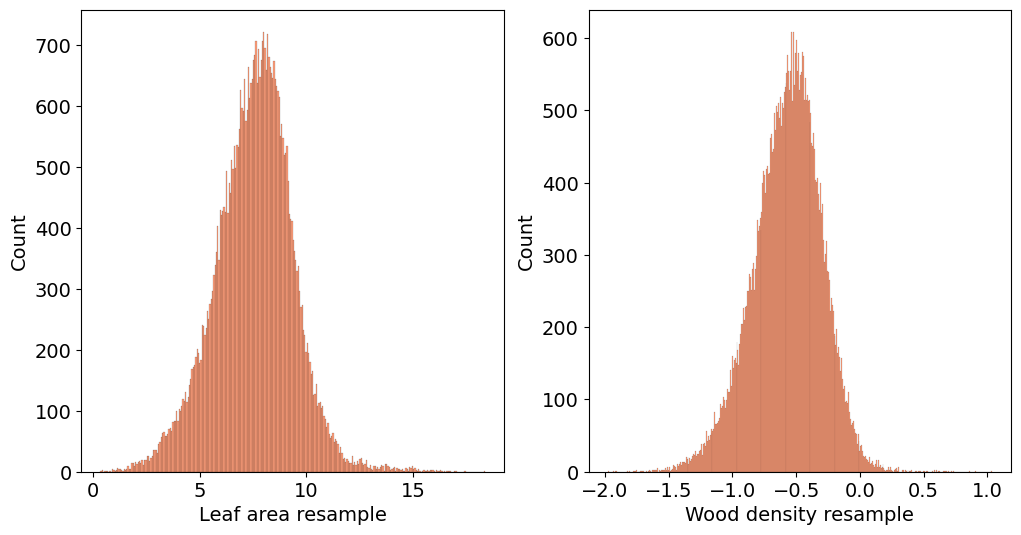

In [33]:
# PLOT HISTOGRAM FOR Leaf area and Wood density
df_resample = df_pred.copy()
df_resample['Leaf area resample'] = resample_trait(df_resample['Leaf area'], error_pred_dist['Leaf area'])
df_resample['Wood density resample'] = resample_trait(df_resample['Wood density'], error_pred_dist['Wood density'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df_resample['Leaf area resample'], bins=300, ax=ax[0], color = 'coral')
sns.histplot(df_resample['Wood density resample'], bins=400, ax=ax[1], color='coral')
# fontsize
plt.rcParams.update({'font.size': 14})
plt.show()

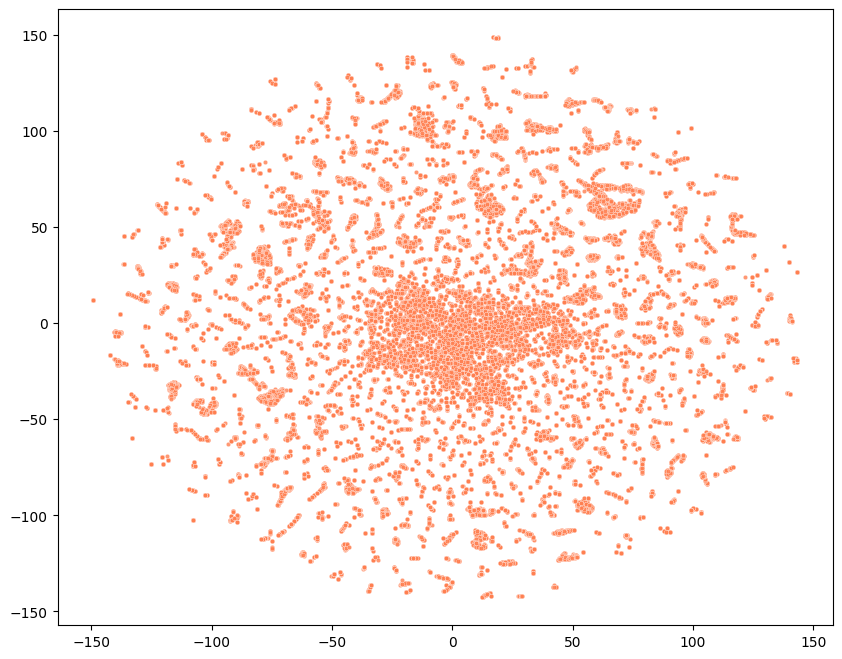

In [25]:
# perform tsne in df_pred
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X_tsne = tsne.fit_transform(df_pred)


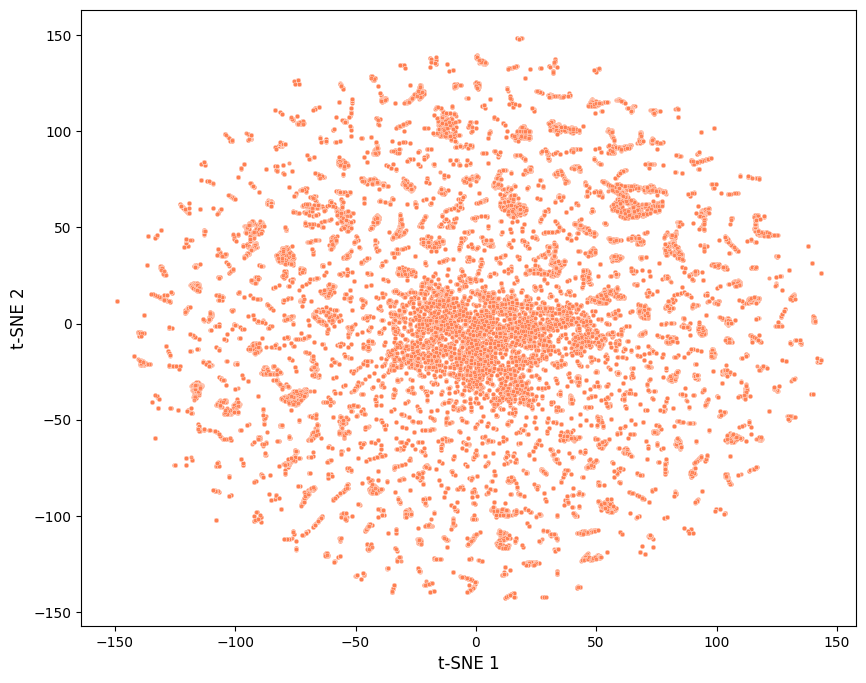

In [29]:
# plot the tsne
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], color='coral', s=10, alpha = 0.8)
# x and y axis names
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.show()

In [39]:
def best_gmm_bic(df_data, n_components_list):
    """Evaluate Gaussian Mixture Models for varying number of components and return the best based on BIC."""
    best_bic = np.inf
    best_n = None
    for n_components in n_components_list:
        gmm = GaussianMixture(n_components=n_components, random_state = 123, n_init=3)
        gmm.fit(df_data)
        bic = gmm.bic(df_data)
        if bic < best_bic:
            best_bic = bic
            best_n = n_components
    return best_n, best_bic



In [12]:
### RESAMPLING APPROACH ####
trait1 = 'Leaf area'
trait2 = 'Wood density'
trait_resampled1 = f'{trait1} resampled'
trait_resampled2 = f'{trait2} resampled'

consensus_matrix = np.zeros((df_gymno_pred.shape[0], df_gymno_pred.shape[0]))

for i in range(20):
    error_list1 = np.array(error_pred_dist['gymnosperm'][trait])
    error_list2 = np.array(error_pred_dist['gymnosperm'][trait2])
    df_gymno_pred.loc[:,trait_resampled1] = resample_trait(df_gymno_pred[trait1], error_list1)
    df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2)

    # fit GMM and get labels
    best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait_resampled1]],
                                                           range(2, 5))
    
    gmm_resampled = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=1)
    gmm_resampled.fit(df_gymno_pred[[trait_resampled1]])
    clusters_resampled = gmm_resampled.predict(df_gymno_pred[[trait_resampled1]])
    for j in range(df_gymno_pred.shape[0]):
        for k in range(j+1, df_gymno_pred.shape[0]):
            if clusters_resampled[j] == clusters_resampled[k]:
                consensus_matrix[j, k] += 1
                consensus_matrix[k, j] += 1

    # # fit HDBSCAN and get labels
    # hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=5)
    # clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[[trait_resampled1, trait_resampled2]]))
    # # grab index that are not -1
    # cluster_index = np.where(clusters_resampled != -1)[0]
    # # add to consensus matrix
    # for j in cluster_index:
    #     for k in cluster_index:
    #         if clusters_resampled[j] == clusters_resampled[k]:
    #             consensus_matrix[j, k] += 1

# normalize consensus matrix
consensus_matrix = consensus_matrix / 20

C:\Users\pablo\AppData\Local\Temp\ipykernel_24724\850665511.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2)


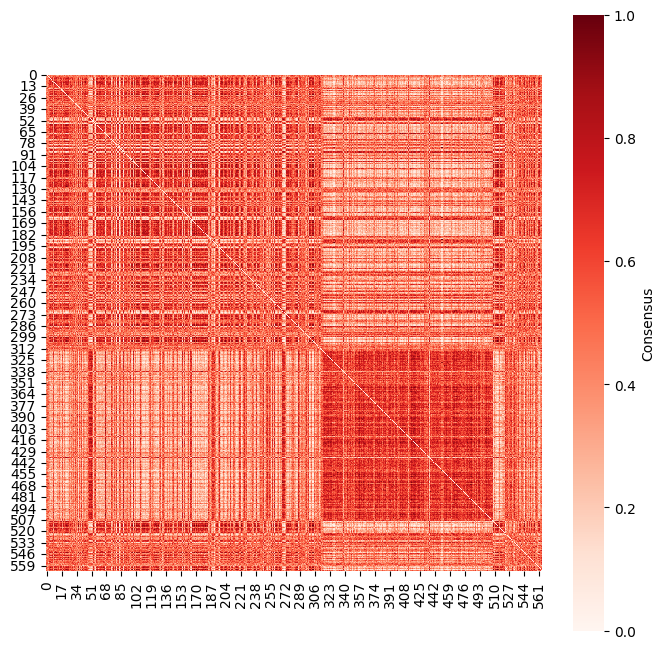

In [13]:
# plot consensus matrix as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(consensus_matrix, cmap='Reds', square=True, cbar_kws={'label': 'Consensus'})
plt.show()

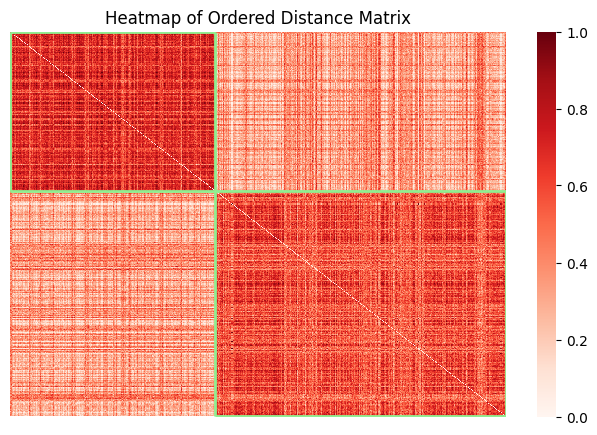

In [14]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


num_clusters = 2
distance_matrix = 1- consensus_matrix
# set diagonal to 0
np.fill_diagonal(distance_matrix, 0)

# Assuming `distance_matrix` is your full square distance matrix
# Convert to condensed distance matrix for clustering
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = sch.linkage(condensed_distance_matrix, method='ward')

# Retrieve cluster labels at a given cutoff (not super sure how this works)
clusters = sch.fcluster(Z, t = num_clusters, criterion='maxclust')

# Order the distance matrix by clusters
order = np.argsort(clusters)  # This gives indices that sort the clusters
ordered_distance_matrix = consensus_matrix[order, :][:, order]


# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(ordered_distance_matrix, cmap='Reds', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Ordered Distance Matrix')

# Draw squares around each cluster
unique_clusters = np.unique(clusters[order])
boundaries = {cluster: (np.min(np.where(clusters[order] == cluster)), np.max(np.where(clusters[order] == cluster))) for cluster in unique_clusters}
for cluster, (start, end) in boundaries.items():
    plt.hlines([start, end+1], start, end+1, color='lightgreen', lw=2)
    plt.vlines([start, end+1], start, end+1, color='lightgreen', lw=2)

# 2 Dimensional Case

C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\273874750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred.loc[:,f'{trait1} resampled'] = df_gymno_pred[trait1] + error_leaf
C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\273874750.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred.loc[:,f'{trait2} resampled'] = df_gymno_pred[trait2] + error_crown


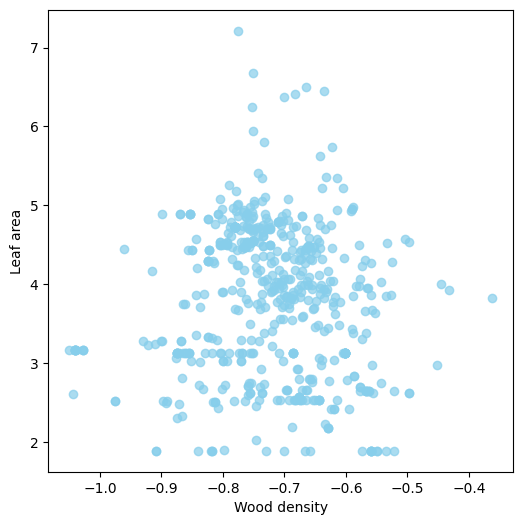

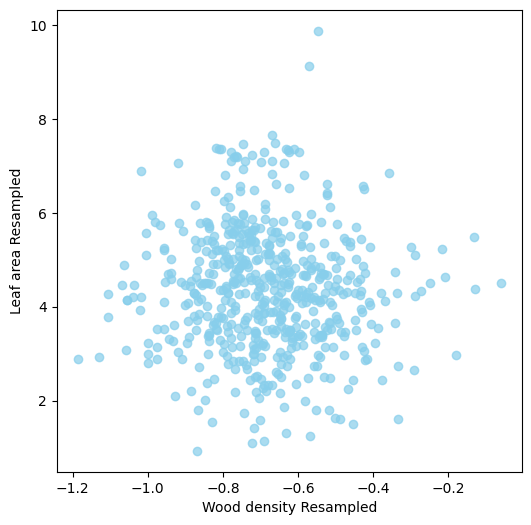

In [10]:
# Define the traits
# trait1, trait2 = 'Leaf area', 'Tree height'
trait1, trait2 = 'Wood density', 'Leaf area'
trait1_resampled, trait2_resampled = f'{trait1} resampled', f'{trait2} resampled'


# Sample random errors for both traits
error_leaf = np.random.choice(error_pred_dist['gymnosperm'][trait1], len(df_gymno_pred), replace=True)
error_crown = np.random.choice(error_pred_dist['gymnosperm'][trait2], len(df_gymno_pred), replace=True)

# Create resampled data columns
df_gymno_pred.loc[:,f'{trait1} resampled'] = df_gymno_pred[trait1] + error_leaf
df_gymno_pred.loc[:,f'{trait2} resampled'] = df_gymno_pred[trait2] + error_crown


#### 2 PLOTS ####
# # Create a figure with subplots for original and resampled data
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)  # 1 row, 2 columns

# # Scatter plot of original data
# axs[0].scatter(df_gymno_pred[trait1], df_gymno_pred[trait2], color='skyblue', alpha=0.7)
# axs[0].set_title(f'Original Data: {trait1} vs {trait2}')
# axs[0].set_xlabel(trait1)
# axs[0].set_ylabel(trait2)

# # Scatter plot of resampled data
# axs[1].scatter(df_gymno_pred[f'{trait1} resampled'], df_gymno_pred[f'{trait2} resampled'], color='skyblue', alpha=0.7)
# axs[1].set_title(f'Resampled Data: {trait1} vs {trait2}')
# axs[1].set_xlabel(f'{trait1} Resampled')
# axs[1].set_ylabel(f'{trait2} Resampled')

# # Show the plots
# plt.tight_layout()
# plt.show()


# Plot original data
plt.figure(figsize=(6, 6))  # Set the figure size for the plot
plt.scatter(df_gymno_pred[trait1], df_gymno_pred[trait2], color='skyblue', alpha=0.7)
# plt.title(f'Original Data: {trait1} vs {trait2}')
plt.xlabel(trait1)
plt.ylabel(trait2)
plt.show()  # This shows the first plot and then closes it

# Plot resampled data
plt.figure(figsize=(6, 6))  # Set the figure size for the plot
plt.scatter(df_gymno_pred[trait1_resampled], df_gymno_pred[trait2_resampled], color='skyblue', alpha=0.7)
# plt.title(f'Resampled Data: {trait1} vs {trait2}')
plt.xlabel(f'{trait1} Resampled')
plt.ylabel(f'{trait2} Resampled')
plt.show()  # This shows the second plot

In [38]:
# Assuming df_gymno_pred contains 'Crown height' and 'Crown height resampled' columns
best_n, best_bic = best_gmm_bic(df_gymno_pred[[trait1, trait2]], range(2, 15))
best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait1_resampled, trait2_resampled]],
                                                     range(2, 15))

In [42]:
# take a subsample of df_pred
# df_pred_subsample = df_pred.sample(10000, random_state=123)

C:\Users\pablo\AppData\Local\Temp\ipykernel_11408\1386163539.py:24: UserWarning: The palette list has more values (1000) than needed (51), which may not be intended.
  sns.scatterplot(x=trait1, y=trait2, data=df_pred, s=8, alpha=0.3,


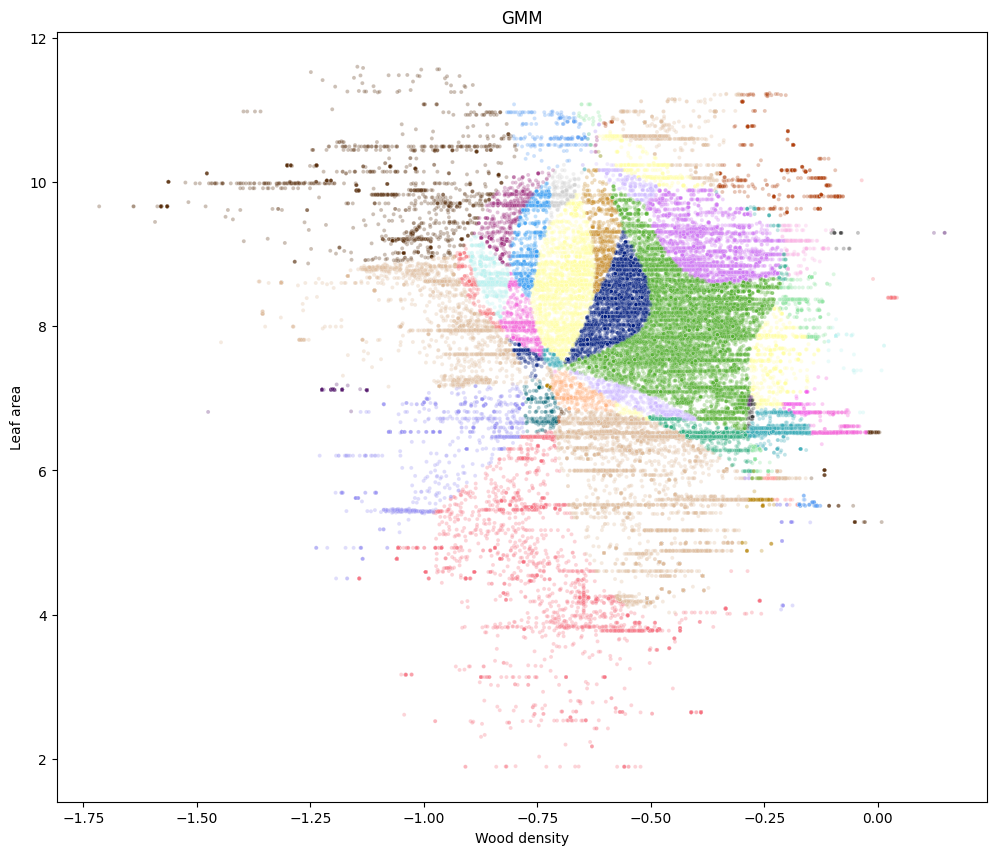

In [16]:
# Perform GMM clustering
gmm_original = GaussianMixture(n_components=1000, random_state=123, n_init=1, init_params='random')
gmm_original.fit(df_pred[[trait1, trait2]])
gmm_original_labels = gmm_original.predict(df_pred[[trait1, trait2]])

# Generate a list of colors from multiple palettes
num_clusters = gmm_original.n_components
colors_dark = sns.color_palette('dark', num_clusters // 3)
colors_pastel = sns.color_palette('pastel', num_clusters // 3)
colors_husl = sns.color_palette('husl', num_clusters // 3)
colors = colors_dark + colors_pastel + colors_husl

# Ensure we have enough colors for all clusters
while len(colors) < num_clusters:
    colors += colors

# Trim the list to the number of clusters
colors = colors[:num_clusters]
# shuffle
np.random.shuffle(colors)

# Plot clusters with unique colors
plt.figure(figsize=(12, 10))
sns.scatterplot(x=trait1, y=trait2, data=df_pred, s=8, alpha=0.3,
                hue=gmm_original_labels, palette=colors, legend=False)
plt.title('GMM')

plt.show()

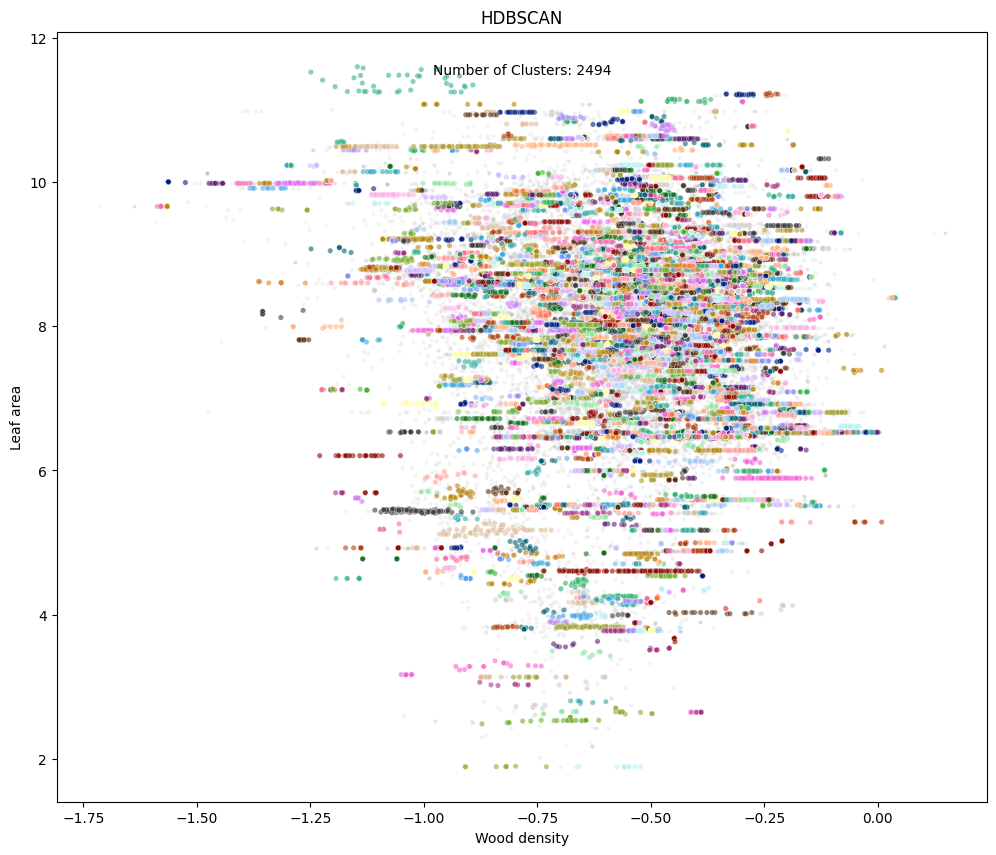

Number of clusters: 1933


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import numpy as np

# Perform HDBSCAN clustering
hdbscan_label_original = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(df_pred[[trait1, trait2]])

# Create a boolean mask for noise points
noise_mask = (hdbscan_label_original == -1)

# Generate colors from multiple palettes
num_clusters = len(np.unique(hdbscan_label_original)) - 1
colors_dark = sns.color_palette('dark', num_clusters // 3)
colors_pastel = sns.color_palette('pastel', num_clusters // 3)
colors_husl = sns.color_palette('husl', num_clusters // 3)
colors = colors_dark + colors_pastel + colors_husl

# Ensure we have enough colors for all clusters
while len(colors) < num_clusters:
    colors += colors

# Trim the list to the number of clusters
colors = colors[:num_clusters]
# shuffle
np.random.shuffle(colors)

# # Create a color map based on cluster IDs
# color_map = np.array([colors[cluster_id % len(colors)] for cluster_id in hdbscan_label_original])



# Plot noise points first
plt.figure(figsize=(12, 10))
sns.scatterplot(x=trait1, y=trait2, data=df_pred[noise_mask], s=8, alpha=0.1, color='gray')

# Plot all clusters in a single call
sns.scatterplot(x=trait1, y=trait2, data=df_pred[~noise_mask], s=15, alpha=0.6, palette=colors, hue=hdbscan_label_original[~noise_mask], legend=False)
# show number of clusters in box
plt.text(0.5, 0.95, f'Number of Clusters: {num_clusters}', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# title
plt.title('HDBSCAN')
plt.show()

hdbscan_label_total = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(df_pred)
# count number of clusters
num_clusters_total = len(np.unique(hdbscan_label_total))-1
print(f'Number of clusters: {num_clusters_total}')


<Axes: xlabel='count', ylabel='Count'>

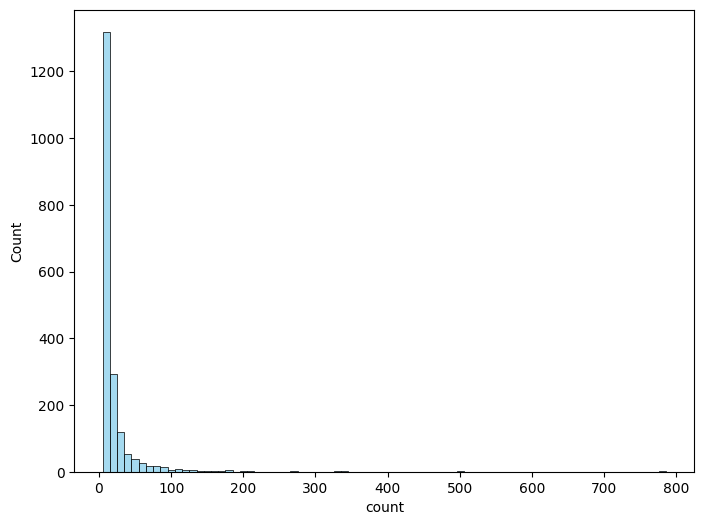

In [19]:
### See distribution of clusters
# value counts
cluster_labels = hdbscan_label_total[hdbscan_label_total != -1]
cluster_counts = pd.Series(cluster_labels).value_counts()

# plot histogram of cluster counts
plt.figure(figsize=(8, 6))
sns.histplot(cluster_counts, color='skyblue', binwidth=10)

Consensus Clustering Gif

In [ ]:
# Perform GMM clustering
gmm_original = GaussianMixture(n_components=30, random_state=123, n_init=1, init_params='random')
gmm_original.fit(df_pred[[trait1, trait2]])
gmm_original_labels = gmm_original.predict(df_pred[[trait1, trait2]])

# Generate a list of colors from multiple palettes
num_clusters = gmm_original.n_components
colors_dark = sns.color_palette('dark', num_clusters // 3)
colors_pastel = sns.color_palette('pastel', num_clusters // 3)
colors_husl = sns.color_palette('husl', num_clusters // 3)
colors = colors_dark + colors_pastel + colors_husl

# Ensure we have enough colors for all clusters
while len(colors) < num_clusters:
    colors += colors

# Trim the list to the number of clusters
colors = colors[:num_clusters]
# shuffle
np.random.shuffle(colors)

# Plot clusters with unique colors
plt.figure(figsize=(12, 10))
sns.scatterplot(x=trait1, y=trait2, data=df_pred, s=8, alpha=0.3,
                hue=gmm_original_labels, palette=colors, legend=False)
plt.title('GMM')

plt.show()

In [35]:

def resample_traits(df_traits_pred, error_dic, N_gymnosperm, N_angiosperm, gymnosperm, angiosperm, observed_traits, df_traits_obs, trait_list=None):
    if trait_list is None:
        trait_list = df_traits_pred.columns

    error_weight = 1
    N_species = df_traits_pred.shape[0]
    N_columns = len(trait_list)

    # Initialize the resampled DataFrame with NaNs
    X_s = pd.DataFrame(np.ones((N_species, N_columns)) * np.nan, columns=trait_list, index=df_traits_pred.index)

    for index_trait, trait in enumerate(trait_list):
        # Gymnosperm resample
        sampled_error_gym = np.random.choice(error_dic['gymnosperm'][trait], N_gymnosperm, replace=True)*error_weight
        X_s.loc[gymnosperm, trait] = df_traits_pred.loc[gymnosperm, trait].copy() + sampled_error_gym

        # Angiosperm resample
        sampled_error_ang = np.random.choice(error_dic['angiosperm'][trait], N_angiosperm, replace=True)*error_weight
        X_s.loc[angiosperm, trait] = df_traits_pred.loc[angiosperm, trait].copy() + sampled_error_ang

        if trait in observed_traits:
            # Refill those with complete data
            complete_index = df_traits_obs[trait].dropna().index
            # Intersect with df_traits_pred.index
            complete_index = np.intersect1d(complete_index, df_traits_pred.index)
            X_s.loc[complete_index, trait] = df_traits_pred.loc[complete_index, trait].copy()

    return X_s

In [51]:
import imageio

# Parameters for resampling
N_gymnosperm = df_gymno.shape[0]
N_angiosperm = df_angio.shape[0]
gymnosperms = df_gymno['accepted_bin']
angiosperms = df_angio['accepted_bin']
observed_traits = df_obs.columns
num_iterations = 5  # Define the number of iterations for the GIF
trait_list = ['Leaf area', 'Wood density']
n_cluster_list = []

# Create a directory to store the images
output_presentation = 'output/presentation/'
if not os.path.exists(output_presentation):
    os.makedirs(output_presentation)

# Generate a list of colors from multiple palettes
colors_dark = sns.color_palette('dark', 110)
colors_pastel = sns.color_palette('pastel', 110)
colors_husl = sns.color_palette('husl', 110)
colors = colors_dark + colors_pastel + colors_husl

# Ensure we have enough colors for all clusters
while len(colors) < num_clusters:
    colors += colors

# Trim the list to the number of clusters
colors = colors[:num_clusters]
np.random.shuffle(colors)


# Calculate axis limits based on the provided data frames or a predefined range
x_min, x_max = df_pred[trait1].min(), df_pred[trait1].max()
y_min, y_max = df_pred[trait2].min(), df_pred[trait2].max()


# Generate images for each iteration
filenames = []
for i in range(num_iterations):
    # Resample the traits
    df_traits_pred_resampled = resample_traits(df_pred, error_pred_dist, N_gymnosperm, N_angiosperm,
                                               gymnosperms, angiosperms, observed_traits, 
                                               df_obs, trait_list=trait_list)

    # Perform GMM clustering
    # obtain best number of clusters
    # components_list = [10,20,30,40,50]
    components_list = [2,3,4,5,6,7,8]
    best_n_resampled, best_bic_resampled = best_gmm_bic(df_traits_pred_resampled[[trait1, trait2]], components_list)
    gmm_s = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=1, init_params='random')
    gmm_s.fit(df_traits_pred_resampled[[trait1, trait2]])
    gmm_labels = gmm_s.predict(df_traits_pred_resampled[[trait1, trait2]])
    num_clusters = best_n_resampled

    # # Perform HDBSCAN
    # hdbscan_label_original = hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(df_traits_pred_resampled[[trait1, trait2]])
    # # num of clusters
    # num_clusters = len(np.unique(hdbscan_label_original)) - 1
    # # noise mask
    # noise_mask = (hdbscan_label_original == -1)



    # Plot clusters with unique colors
    plt.figure(figsize=(12, 10))
    # Plot noise points first
    # HDBSCAN
    # sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled[noise_mask], s=8, alpha=0.2, color='gray')
    # sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled[~noise_mask], s=8, alpha=0.6,
    #                 hue=hdbscan_label_original[~noise_mask], palette=colors, legend=False)

    # GMM
    sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled, s=8, alpha=0.6,
                    hue=gmm_labels, palette=colors, legend=False)
    
    # Set the axis limits
    plt.xlim(x_min - 0.2, x_max + 0.2)
    plt.ylim(y_min - 1.5, y_max + 1.5)

    # show number of clusters in box
    plt.text(0.5, 0.95, f'Number of Clusters: {num_clusters}', 
        transform=plt.gca().transAxes, 
        fontsize=12, 
        bbox=dict(
            facecolor='lightgray', 
            edgecolor='black', 
            boxstyle='square,pad=0.5'
        )
    )


# Add iteration number in a styled box
    plt.text(0.05, 0.95, f'Resampling iteration {i+1}', transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='dimgray',
                                                          facecolor='paleturquoise', alpha=0.8))
    
    # Save the frame
    # filename = f'frames/frame_{i}.png'
    filename = f'{output_presentation}frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

    # add number of clusters
    n_cluster_list.append(num_clusters)


C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\3589171947.py:74: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled, s=8, alpha=0.6,
C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\3589171947.py:74: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled, s=8, alpha=0.6,
C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\3589171947.py:74: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=trait1, y=trait2, data=df_traits_pred_resampled, s=8, alpha=0.6,


In [52]:
# Create GIF with slower speed
gif_path = os.path.join(output_presentation, 'resampling_animation_gmm.gif')
with imageio.get_writer(gif_path, mode='I', duration=800) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


# Remove the frames after creating the GIF
for filename in filenames:
    os.remove(filename)

print('GIF created successfully!')

C:\Users\pablo\AppData\Local\Temp\ipykernel_7576\1475257441.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully!


Text(0, 0.5, 'Frequency')

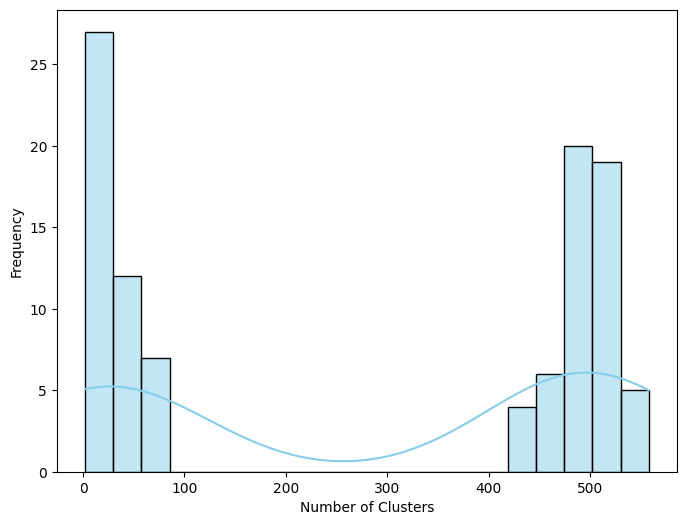

In [28]:
# plot distribution of n_cluster_list
plt.figure(figsize=(8, 6))
sns.histplot(n_cluster_list, bins=20, color='skyblue', kde=True)
# x axis
plt.xlabel('Number of Clusters')
# y axis
plt.ylabel('Frequency')

In [20]:
### RESAMPLING APPROACH ####
# trait1 = 'Wood density'
# trait2 = 'Leaf K per mass'
# trait_resampled1 = f'{trait1} resampled'
# trait_resampled2 = f'{trait2} resampled'

consensus_matrix = np.zeros((df_gymno_pred.shape[0], df_gymno_pred.shape[0]))
n_samples = 500

for i in range(n_samples):
    error_list1 = np.array(error_pred_dist['gymnosperm'][trait])
    error_list2 = np.array(error_pred_dist['gymnosperm'][trait2])
    df_gymno_pred.loc[:,trait_resampled1] = resample_trait(df_gymno_pred[trait1], error_list1)
    df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2)

    # fit GMM and get labels
    best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait_resampled1,trait_resampled2]],
                                                           range(2, 5))
    
    gmm_resampled = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=1)
    gmm_resampled.fit(df_gymno_pred[[trait_resampled1,trait_resampled2]])
    clusters_resampled = gmm_resampled.predict(df_gymno_pred[[trait_resampled1,trait_resampled2]])
    for j in range(df_gymno_pred.shape[0]):
        for k in range(j+1, df_gymno_pred.shape[0]):
            if clusters_resampled[j] == clusters_resampled[k]:
                consensus_matrix[j, k] += 1
                consensus_matrix[k, j] += 1

    # # fit HDBSCAN and get labels
    # hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=5)
    # clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[[trait_resampled1, trait_resampled2]]))
    # # grab index that are not -1
    # cluster_index = np.where(clusters_resampled != -1)[0]
    # # add to consensus matrix
    # for j in cluster_index:
    #     for k in cluster_index:
    #         if clusters_resampled[j] == clusters_resampled[k]:
    #             consensus_matrix[j, k] += 1

# normalize consensus matrix
consensus_matrix = consensus_matrix / n_samples

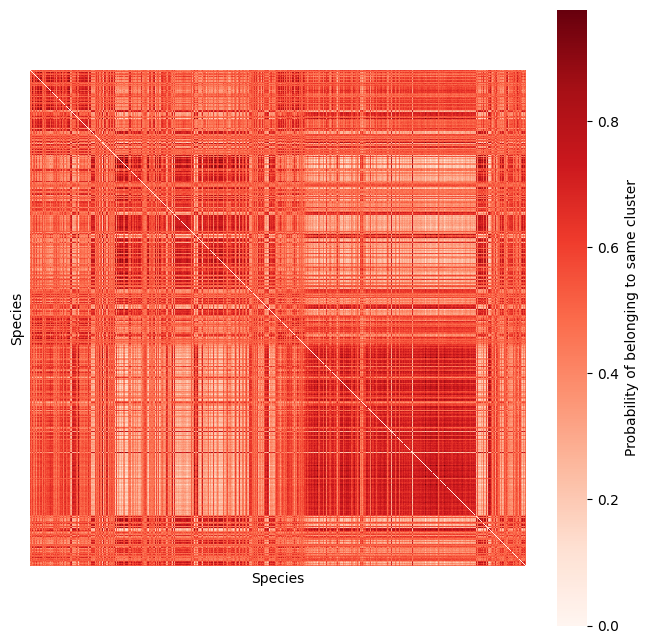

In [21]:

# plot consensus matrix as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(consensus_matrix, cmap='Reds', square=True, 
            cbar_kws={'label': 'Probability of belonging to same cluster'})
# x axis name
plt.xlabel('Species')
plt.ylabel('Species')
# no ticks
plt.xticks([])
plt.yticks([])

plt.show()

Text(119.44444444444444, 0.5, 'Species')

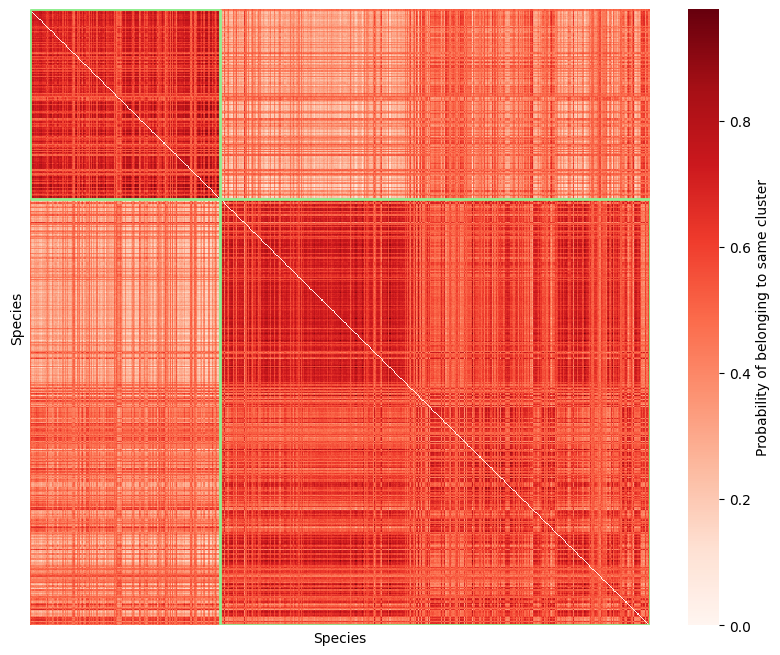

In [22]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


num_clusters = 2
distance_matrix = 1- consensus_matrix
# set diagonal to 0
np.fill_diagonal(distance_matrix, 0)

# Assuming `distance_matrix` is your full square distance matrix
# Convert to condensed distance matrix for clustering
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = sch.linkage(condensed_distance_matrix, method='ward')

# Retrieve cluster labels at a given cutoff (not super sure how this works)
consensus_labels = sch.fcluster(Z, t = num_clusters, criterion='maxclust')

# Order the distance matrix by clusters
order = np.argsort(consensus_labels)  # This gives indices that sort the clusters
ordered_distance_matrix = consensus_matrix[order, :][:, order]


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_distance_matrix, cmap='Reds', xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Probability of belonging to same cluster'})
# plt.title('Heatmap of Ordered Distance Matrix')

# Draw squares around each cluster
unique_clusters = np.unique(consensus_labels[order])
boundaries = {cluster: (np.min(np.where(consensus_labels[order] == cluster)), np.max(np.where(consensus_labels[order] == cluster))) for cluster in unique_clusters}
for cluster, (start, end) in boundaries.items():
    plt.hlines([start, end+1], start, end+1, color='lightgreen', lw=2)
    plt.vlines([start, end+1], start, end+1, color='lightgreen', lw=2)
# cbar label
# plt.colorbar.set_label('Probability of belonging to same cluster')
# x and y axis label
plt.xlabel('Species')
plt.ylabel('Species')

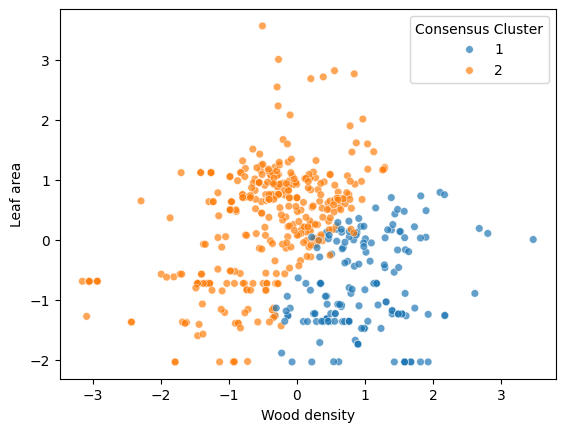

In [23]:
# create figure to show both scatter plots with HDBSCAN
# fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Original data
sns.scatterplot(x=trait1, y = trait2, data=df_gymno_pred, s=30, alpha=0.7,
                hue=consensus_labels, palette='tab10', legend=True)
# legend name
plt.legend(title='Consensus Cluster')

# # Resampled data
# sns.scatterplot(x=trait1_resampled, y = trait2_resampled, data=df_gymno_pred, s=30, alpha=0.7,
#                 hue = hdbscan_label_resampled, palette='tab10', ax=ax[1], legend=True)

# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
